# Lab 3: Geostatistical simulation

### Laila Zaidi

In this lab, you will compute the variogram for your radar topography measurements, which describes its roughness. 

Refer to the Scikit-Gstat and GStatSim Jupyter Book tutorials for guidance: 

https://gatorglaciology.github.io/gstatsimbook/intro.html 

https://scikit-gstat.readthedocs.io/en/latest/

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import skgstat as skg
from sklearn.preprocessing import QuantileTransformer
from mpl_toolkits.axes_grid1 import make_axes_locatable
import gstatsim as gs

### First, load your radar data from Lab 1. 

If you did not save a csv file with your radar bed measurements, you can do that by re-running the radar data cropping section in Lab 1 and saving a csv file. Alternatively, you can load and crop the radar data here using your domain coordinates. 

Remember, you will need to save the bed elevation, not ice thickness, by subtracting thickness from the ice surface. In Lab1, this was done in this line: df['bed'] = df['surf'].values - radar_thickness.flatten()

So save a csv with df['bed'] and the coordinates.

Make sure to drop any rows with NaN values. You can do that with df = df.dropna()

In [2]:
df_bed = pd.read_csv('RutfordIceStreamDataGridded.csv')
df_bed = df_bed[df_bed['bed'] <= 700]
df_bed.head()

,x,y,surf,bed,velx,vely,smb,dhdt,highvel_mask,bedmap_mask,bedmap_surf,bedmachine_source,bedmachine_thickness,bedmap_bed
17,-1452750,14750,1255.0,-1483.0,8.625309,25.548434,0.522560,0.156641,False,1.0,1255.0,5.0,2744.297119,-1487.0
18,-1452250,14750,1254.0,-1484.0,7.685659,27.015002,0.522035,0.158561,False,1.0,1254.0,5.0,2743.005371,-1478.0
29,-1446750,14750,1277.0,-1247.5,8.019951,34.581880,0.516259,0.173216,False,1.0,1277.0,5.0,2656.028320,-1288.0
30,-1446250,14750,1279.0,-1245.5,8.550365,35.578212,0.515734,0.174460,False,1.0,1279.0,5.0,2651.127808,-1257.0
31,-1445750,14750,1282.0,-1249.7,8.608857,35.942447,0.515209,0.175762,False,1.0,1282.0,3.0,2647.447388,-1319.0


In [3]:
len(df_bed)

40090

Now let's plot your data. You'll want to change vmin and vmax to suit your data range.

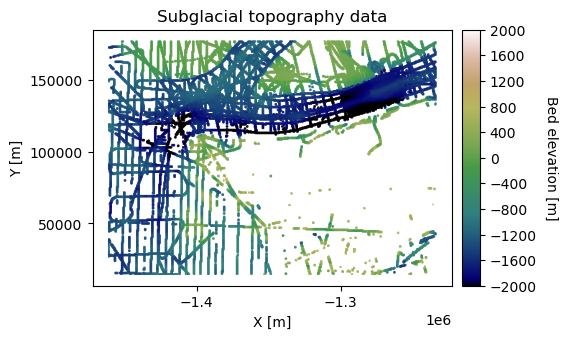

In [4]:
# plot data
fig = plt.figure(figsize = (5,5))
ax = plt.gca()
im = ax.scatter(df_bed['x'], df_bed['y'], c=df_bed['bed'], vmin=-2000, vmax=2000, 
                     marker='.', s=0.5, cmap='gist_earth')
plt.title('Subglacial topography data')
plt.xlabel('X [m]'); plt.ylabel('Y [m]')
plt.locator_params(nbins=5)
plt.axis('scaled')

# make colorbar
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.1)
cbar = plt.colorbar(im, ticks=np.linspace(-2000, 2000, 11), cax=cax)
cbar.set_label("Bed elevation [m]", rotation=270, labelpad=15)
plt.show()

In [5]:
res = 1000  
df_grid, grid_matrix, rows, cols = gs.Gridding.grid_data(df_bed, 'x', 'y', 'bed', res)

### Normal score transformation

Geostatistical methods typically require Gaussian assumptions, so we need to perform a normal score transformation to convert to a standard Gaussian distribution (mean = 0, standard deviaton = 1, Gaussian shape). After performing a geostatistical interpolation, we will back-transform the interpolation to recover the original distribution.

In [26]:
# normal score transformation
data = df_bed['bed'].values.reshape(-1,1)
nst_trans = QuantileTransformer(n_quantiles=500, output_distribution='normal').fit(data)
df_bed['Nbed'] = nst_trans.transform(data)

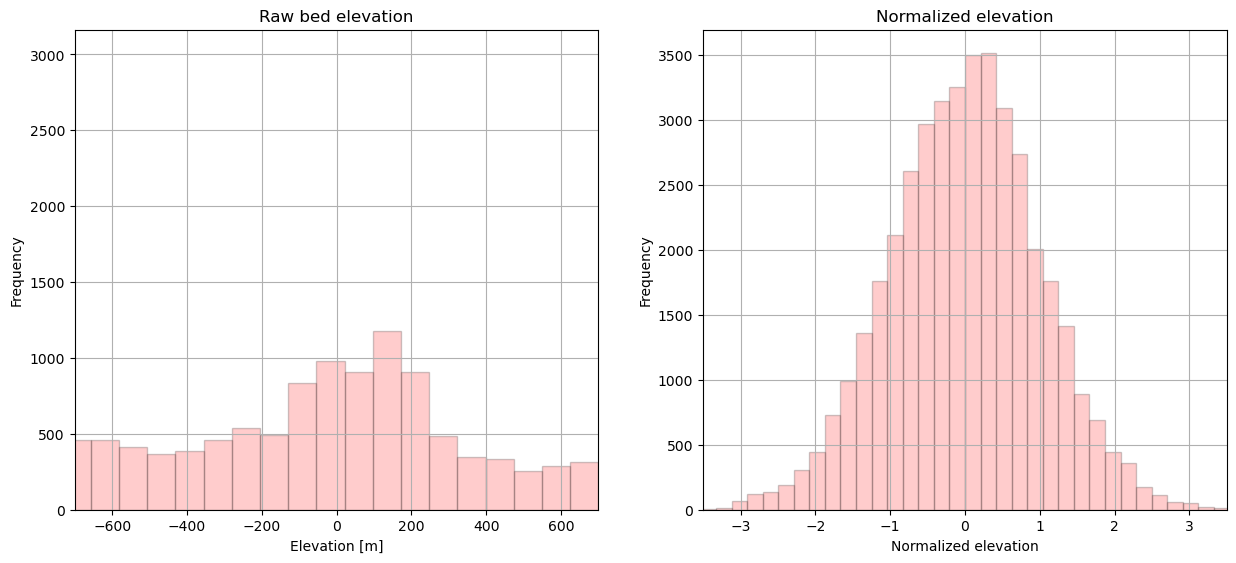

In [27]:
# plot original bed histogram
plt.subplot(121)
plt.hist(df_bed['bed'], facecolor='red', bins=50, alpha=0.2, edgecolor='black')
plt.xlim([-700,700]); 
plt.xlabel('Elevation [m]'); plt.ylabel('Frequency'); plt.title('Raw bed elevation')
plt.grid(True)

# plot normal score bed histogram (with weights)
plt.subplot(122)
plt.hist(df_bed['Nbed'], facecolor='red', bins=50, alpha=0.2, edgecolor='black')
plt.xlim([-3.5,3.5]); 
plt.xlabel('Normalized elevation'); plt.ylabel('Frequency'); plt.title('Normalized elevation')
plt.grid(True)
plt.subplots_adjust(left=0.0, bottom=0.0, right=1.8, top=1.0, wspace=0.2, hspace=0.3)
plt.show()

__Q1: How do the before and after transformation histograms compare? Why is this step important?__

Answer: The Raw bed elevation histogram is considered more non-regular and has a noticeably big difference in the frequency level as compared to the normalized elevation. The Normalized elevation histogram is a bell-shaped curve and in fact a normal distribution. 

### Compute the experimental variogram

The variogram is how we "learn" the roughness of the topography.

When computing the variogram, we'll randomly drop out a fraction of the points to speed up the variogram calculation. Don't worry, the variogram will still be fairly robust. You might need to play around with this percentage, depending on how much data you have.

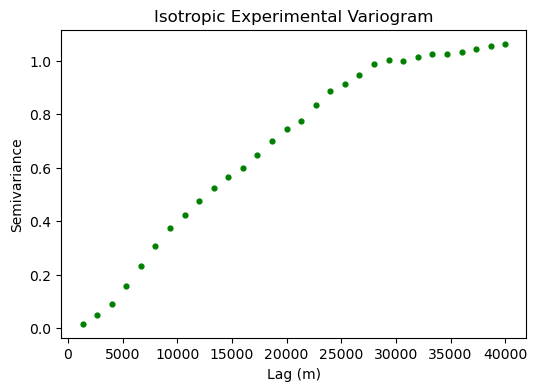

In [28]:
df_sampled = df_bed.sample(frac=0.5, random_state=42)

# compute experimental (isotropic) variogram
coords = df_sampled[['x','y']].values
values = df_sampled['Nbed']

maxlag = 40000      # maximum range distance
n_lags = 30         # num of bins (try decreasing if this is taking too long)

# compute variogram
V1 = skg.Variogram(coords, values, bin_func='even', n_lags=n_lags, maxlag=maxlag, normalize=False)

# extract variogram values
xdata = V1.bins
ydata = V1.experimental

plt.figure(figsize=(6,4))
plt.scatter(xdata, ydata, s=12, c='g')
plt.title('Isotropic Experimental Variogram')
plt.xlabel('Lag (m)'); plt.ylabel('Semivariance')
plt.show()

__Q2: By looking at your variogram model, roughly what is your sill and range? What do these parameters represent? Why does the semivariance axis go up to ~1?__

Answer: The sill is 1.0 and the range is between 25,000 to 30,000. The sill represents the part wehre the spatial correlation stops increasing which symbolizes the variance of the model. The range is used to show at what point the dataset is not spatially correlated. The semivariance goes to 1 which means the data is normalized. 

### Fit variogram model

Now we need to fit variogram model parameters to the experimental variogram. We will use these model parameters when we perform our simulations.

There are many different variogram model types. We will use the Matern variogram because it has an extra parameter which helps the model fit extra well, and I think this model type tends to produce the most believable looking topography.

Read up on variogram modeling here: https://scikit-gstat.readthedocs.io/en/latest/auto_examples/tutorial_03_variogram_models.html#sphx-glr-auto-examples-tutorial-03-variogram-models-py 

In [29]:
from skgstat import models
# use matern variogram model
V1.model = 'matern' 
V1.parameters


[36855.548692346, 1.0635568233836175, 2.138031515650854, 0]

__Q3: Describe each parameter? How does this compare to your guess in Q2?__

Answer: The sill (1.06) is still relatively close to the visualization of the sill in the map. The range is considered larger than the one shown in the graph. This shows that the spatial correlation ranges further than the graph's representation. The shape shows the semivariance rises quickly which quantifies the curvature. Lastly, the 0 nuggest shows that the parameters were consistent with the rise from 0 from the graph. 

In [30]:
# evaluate models
xi =np.linspace(0, xdata[-1], 100) 

y_matern = skg.models.matern(xi, V1.parameters[0], V1.parameters[1], V1.parameters[2], V1.parameters[3])

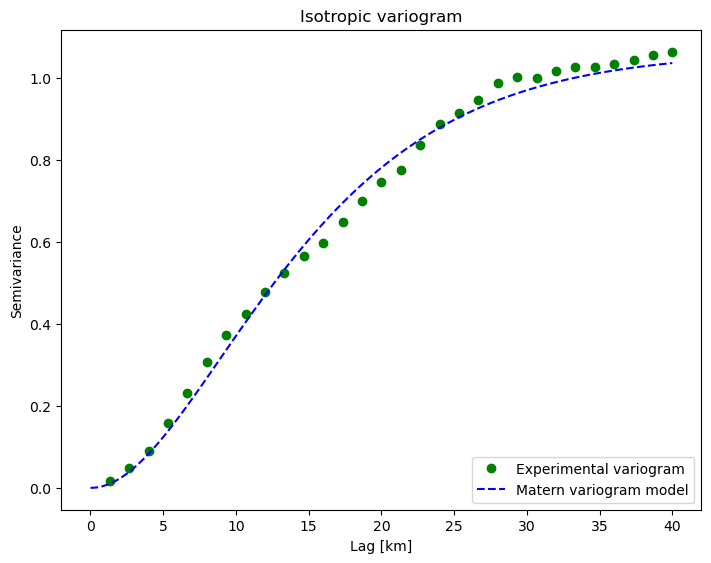

In [31]:
# plot variogram model
fig = plt.figure()
plt.plot(xdata/1000,ydata,'og', label = "Experimental variogram")
plt.plot(xi/1000, y_matern,'b--', label='Matern variogram model')
plt.title('Isotropic variogram')
plt.xlabel('Lag [km]'); plt.ylabel('Semivariance')  
plt.subplots_adjust(left=0.0, bottom=0.0, right=1, top=1.0) # adjust the plot size
plt.legend(loc='lower right')

### Now that we have our variogram parameters, we can move on to simulation

First, we need to initialize a simulation grid. This will ensure your data is properly gridded. 

In [32]:
# grid data to 500 m resolution and remove coordinates with NaNs
res = 2000
df_grid, grid_matrix, rows, cols = gs.Gridding.grid_data(df_bed, 'x', 'y', 'Nbed', res)
df_grid = df_grid[df_grid["Z"].isnull() == False]
df_grid = df_grid.rename(columns = {"Z": "Nbed"}) # rename last column

# define coordinate grid
xmin = np.min(df_grid['X']); xmax = np.max(df_grid['X'])     # min and max x values
ymin = np.min(df_grid['Y']); ymax = np.max(df_grid['Y'])     # min and max y values

pred_grid = gs.Gridding.prediction_grid(xmin, xmax, ymin, ymax, res)

In [33]:
df_grid.head()

,X,Y,Sum,Count,Nbed
1,-1473750.0,750.0,2.734785,6.0,0.455797
2,-1471750.0,750.0,1.755735,4.0,0.438934
4,-1467750.0,750.0,2.277636,6.0,0.379606
8,-1459750.0,750.0,3.164613,8.0,0.395577
9,-1457750.0,750.0,2.705525,8.0,0.338191


Let's set up our simulation. We'll need the variogram parameters, and we als oneed to decide our number of nearest neighboring conditioning points and search radius.

In [34]:
# save variogram parameters as a list
azimuth = 0
nugget = 0 # make nugget 0

# the major and minor ranges are the same in this example because it is isotropic
major_range = V1.parameters[0]
minor_range = V1.parameters[0]
sill = V1.parameters[1]
smoothness = V1.parameters[2]
vtype = 'matern'
vario_list = [azimuth, nugget, major_range, minor_range, sill, 'matern', smoothness]

k = 48         # number of neighboring data points used to estimate a given point 
rad = 80000    # 70 km search radius

sim = gs.Interpolation.okrige_sgs(pred_grid, df_grid, 'X', 'Y', 'Nbed', k, vario_list, rad, quiet=False, seed=0)
sim_trans = nst_trans.inverse_transform(sim.reshape(-1,1)).squeeze() # back transformation

100%|█████████████████████████████████████████████████████████████████████████████| 9775/9775 [01:15<00:00, 129.48it/s]


This might take a while! While you are working on the code, you might want to temporarily coarsen the resolution to save time.

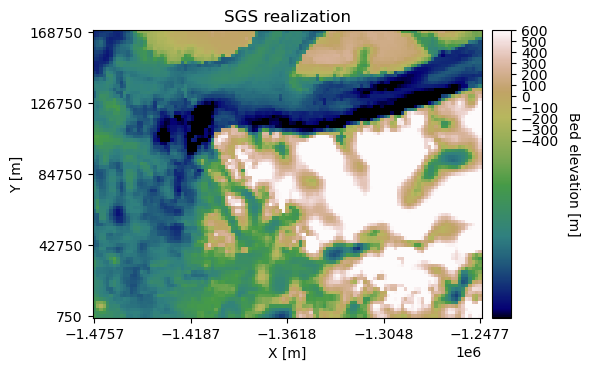

In [35]:
# plot simulation
x_mat = pred_grid[:,0].reshape((rows, cols))
y_mat = pred_grid[:,1].reshape((rows, cols))
sgs_mat = sim_trans.reshape((rows, cols))

fig, ax = plt.subplots(figsize=(6, 5))

im = ax.pcolormesh(x_mat, y_mat, sgs_mat, vmin=-2000, vmax=600, cmap='gist_earth')
ax.set_title('SGS realization')
ax.set_xlabel('X [m]')
ax.set_ylabel('Y [m]')

ax.set_xticks(np.linspace(xmin, xmax, 5))
ax.set_yticks(np.linspace(ymin, ymax, 5))

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.1)
cbar = plt.colorbar(im, ticks=np.linspace(-400, 600, 11), cax=cax)
cbar.set_label("Bed elevation [m]", rotation=270, labelpad=15)

ax.axis('scaled')

plt.tight_layout()
plt.show()

Load in your BedMachine data and plot the topography for this region.

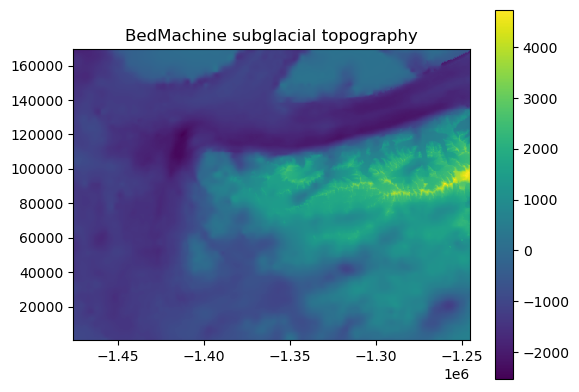

In [38]:
df = pd.read_csv('RutfordIceStreamDataGridded.csv')
xx, yy = np.meshgrid(np.unique(df.x), 
                     np.unique(df.y))

surf = df['surf'].values.reshape(xx.shape)
bedmap_bed = df['bedmap_bed'].values.reshape(xx.shape)
velx = df['velx'].values.reshape(xx.shape)
vely = df['vely'].values.reshape(xx.shape)
dhdt = df['dhdt'].values.reshape(xx.shape)
smb = df['smb'].values.reshape(xx.shape)
bedmachine_thickness = df['bedmachine_thickness'].values.reshape(xx.shape)
bedmachine_bed = surf - bedmachine_thickness

plt.pcolormesh(xx,yy,bedmachine_bed)
plt.title('BedMachine subglacial topography')
plt.axis('scaled')
plt.colorbar()

__Q4: Visually, how does your simulated topography compare to BedMachine? Why do they differ?__

Answer: The SGS realization is a model output which means that it relflects the actual topography using statistical properties like variance and spatial correlation. The BedMachine topography shows a more smoother, more interpolated observation. Because of these different approaches used to map the topography, the visualizations are completely different. The SGS realization is on a small scale which results in the blockier appearance while BedMachine can resolve this roughness to be physically realistic to the geophysical constraints. Notice how the BedMachine has a larger elevation range than the SGS realization. 

## Variogram comparison

Now you are going to compare the variograms for BedMachine and your simulation. Compute the experimental variograms for both BedMachine and your simulated (back-transformed) topography. Plot the two experimental variograms.

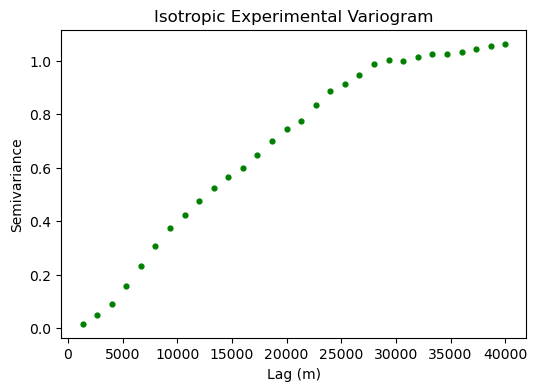

In [41]:
df_sampled = df_bed.sample(frac=0.5, random_state=42)

# compute experimental (isotropic) variogram
coords = df_sampled[['x','y']].values
values = df_sampled['Nbed']

maxlag = 40000      # maximum range distance
n_lags = 30         # num of bins (try decreasing if this is taking too long)

# compute variogram
V1 = skg.Variogram(coords, values, bin_func='even', n_lags=n_lags, maxlag=maxlag, normalize=False)

# extract variogram values
xdata = V1.bins
ydata = V1.experimental

plt.figure(figsize=(6,4))
plt.scatter(xdata, ydata, s=12, c='g')
plt.title('Isotropic Experimental Variogram')
plt.xlabel('Lag (m)'); plt.ylabel('Semivariance')
plt.show()

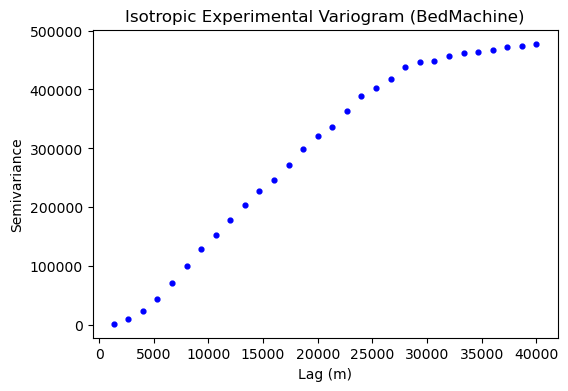

In [49]:
df = pd.read_csv("RutfordIceStreamDataGridded.csv")

# Calculate BedMachine surface
df_bed['bedmachine'] = df_bed['surf'] - df_bed['bedmachine_thickness']

# Drop rows with NaNs in coordinates or bedmachine
df_clean = df_bed.dropna(subset=['x', 'y', 'bedmachine'])

# Optional: sample 50% to speed up computation
df_sampled = df_clean.sample(frac=0.5, random_state=42)

# Coordinates and values
coords = df_sampled[['x','y']].values
values = df_sampled['bedmachine'].values

# Variogram parameters
maxlag = 40000
n_lags = 30

# Compute experimental variogram
V2 = skg.Variogram(coords, values, bin_func='even', n_lags=n_lags, maxlag=maxlag, normalize=False)

# Extract variogram data
xdata = V2.bins
ydata = V2.experimental

# Plot
plt.figure(figsize=(6,4))
plt.scatter(xdata, ydata, s=12, c='b')
plt.title('Isotropic Experimental Variogram (BedMachine)')
plt.xlabel('Lag (m)')
plt.ylabel('Semivariance')
plt.show()


__Q5: How do the experimental variograms differ? How do you interpret these differences?__

Answer: A big difference between the two variograms is the fact that the BedMachine's variogram is arguably more smooth than my simulation. I would still argue that the sill, range, and nugget are still within the same parameters for both simulations. I would interpret this difference as BedMachine is more smooth, even the topography is more smooth than the SGS realization. 